<a href="https://colab.research.google.com/github/woodychang0611/EMNIST/blob/master/EMNIST_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Environment
If running on colab mount google drive, otherwise use 200g drive from NCCU GPU cloud

In [0]:
import sys
import os
if ('google.colab' in sys.modules):
  from google.colab import drive
  drive.mount('/content/gdrive')
  gdrive_root = 'gdrive/My Drive/Deep_Learning/'
  dataset_path = os.path.join(gdrive_root,'Dataset')
else:
  dataset_path = '200g/Dataset'
  pass

if not os.path.exists(dataset_path):
  raise Exception(f'dataset_path "{dataset_path}"" does not exist')


# Load Dataset

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim
import torch.autograd
import torchvision
import torchvision.transforms
import numpy as np
from torchsummary import summary
from matplotlib import pyplot as plt
import datetime

trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (1.0,))])
use_cuda = None
if torch.cuda.is_available():
  print("CUDA available")
  use_cuda = True
else:
  print ("CUDA not available")
  use_cuda = False
if os.path.exists(dataset_path):
  train_set = torchvision.datasets.EMNIST(root=dataset_path, transform=trans,train =True, split="byclass",download=True)
  test_set = torchvision.datasets.EMNIST(root=dataset_path, transform=trans,split="byclass", train =False)
  print (f'Dataset loaded, {train_set.__len__():,} training set, {test_set.__len__():,} testing set')
else:
  print (f'dataset_path "{dataset_path}" not found')
  exit(0)

batch_size = 256

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
print(datetime.datetime.now())
preload_train_data = list(enumerate(train_loader))
print(datetime.datetime.now())
preload_test_data = list(enumerate(test_loader))
print(datetime.datetime.now())

CUDA available
Dataset loaded, 697,932 training set, 116,323 testing set
2020-04-04 08:10:21.301541
2020-04-04 08:12:08.785278
2020-04-04 08:12:25.975252


# Common Functions

In [0]:
ceriation = nn.CrossEntropyLoss()
def apply_model(model,x,target):
    x, target = torch.autograd.Variable(x), torch.autograd.Variable(target)
    out = model(x)
    loss = torch.nn.CrossEntropyLoss()(out, target)
    return out,loss
def plot_graph(name,train_loss,test_loss):
  fig, ax = plt.subplots()
  ax.plot(train_loss,label='train loss')
  ax.plot(test_loss,label='test loss')  
  ax.set(xlabel='epoch', ylabel='Loss',title=name)
  plt.legend()
  plt.show()


# Define DNN

In [0]:
#DNN
class DNN(nn.Module):
    def __init__(self,dropouts=(0,),layer_widths=(512,)):
        super(DNN, self).__init__()
        if (len(dropouts) != len(layer_widths) or len(dropouts)<=0 or len(layer_widths)<=0):
          raise Exception ("dropouts and layer_widths must have same width and greater than 0")
        self.dropouts=dropouts
        self.layer_widths = layer_widths
        input_width = 28*28
        self.fc = nn.ModuleList()
        for width in self.layer_widths:
          self.fc.append(nn.Linear(input_width, width))
          input_width = width
        self.final = nn.Linear(layer_widths[-1], 62)

    def forward(self, x):
        x = x.view(-1, 28*28)
        for dropout, fc in zip(self.dropouts,self.fc):
          x = F.dropout(x,dropout)
          x = fc(x)
          x = F.relu(x)
        x = self.final(x)
        return x
    @property
    def name(self):
        return f"DNN, Width:{self.layer_widths}, Dropout: {self.dropouts}"

2020-04-04 08:21:20.602343
model:DNN, Width:(500, 256), Dropout: (0, 0), parameter:536,690
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
            Linear-2                  [-1, 256]         128,256
            Linear-3                   [-1, 62]          15,934
Total params: 536,690
Trainable params: 536,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.05
Estimated Total Size (MB): 2.06
----------------------------------------------------------------
==>>> epoch: 0, batch index: 2727, train loss: 0.718130
==>>> epoch: 0, batch index: 455, test loss: 0.707064, acc: 0.781
==>>> epoch: 1, batch index: 2727, train loss: 0.579746
==>>> epoch: 1, batch index: 455, test loss: 0.564882, acc: 0.816
==>>> epoch: 2, batch index

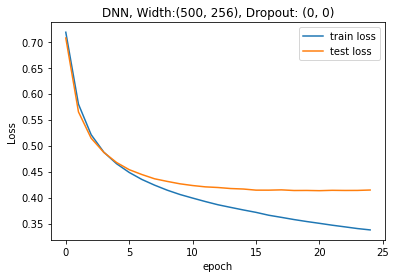

2020-04-04 08:23:19.481236
model:DNN, Width:(700, 256), Dropout: (0, 0), parameter:744,890
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 700]         549,500
            Linear-2                  [-1, 256]         179,456
            Linear-3                   [-1, 62]          15,934
Total params: 744,890
Trainable params: 744,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.84
Estimated Total Size (MB): 2.85
----------------------------------------------------------------
==>>> epoch: 0, batch index: 2727, train loss: 0.713060
==>>> epoch: 0, batch index: 455, test loss: 0.700227, acc: 0.782
==>>> epoch: 1, batch index: 2727, train loss: 0.572380
==>>> epoch: 1, batch index: 455, test loss: 0.561213, acc: 0.816
==>>> epoch: 2, batch index

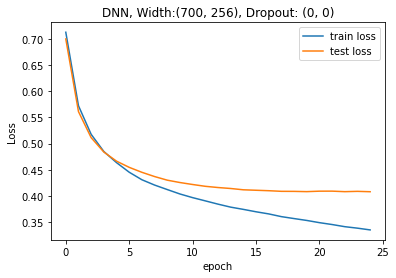

2020-04-04 08:25:18.264161
model:DNN, Width:(700, 500, 256), Dropout: (0, 0, 0), parameter:1,044,190
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 700]         549,500
            Linear-2                  [-1, 500]         350,500
            Linear-3                  [-1, 256]         128,256
            Linear-4                   [-1, 62]          15,934
Total params: 1,044,190
Trainable params: 1,044,190
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.98
Estimated Total Size (MB): 4.00
----------------------------------------------------------------
==>>> epoch: 0, batch index: 2727, train loss: 0.663565
==>>> epoch: 0, batch index: 455, test loss: 0.653548, acc: 0.790
==>>> epoch: 1, batch index: 2727, train loss: 0.539982
==>>> epoch: 1,

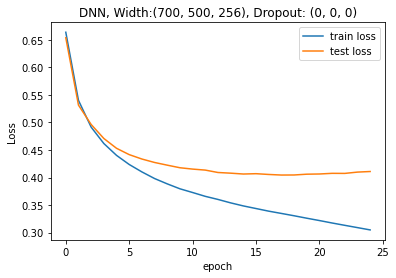

2020-04-04 08:27:38.805245
model:DNN, Width:(700, 500, 256), Dropout: (0.2, 0, 0), parameter:1,044,190
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 700]         549,500
            Linear-2                  [-1, 500]         350,500
            Linear-3                  [-1, 256]         128,256
            Linear-4                   [-1, 62]          15,934
Total params: 1,044,190
Trainable params: 1,044,190
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.98
Estimated Total Size (MB): 4.00
----------------------------------------------------------------
==>>> epoch: 0, batch index: 2727, train loss: 0.723150
==>>> epoch: 0, batch index: 455, test loss: 0.709762, acc: 0.773
==>>> epoch: 1, batch index: 2727, train loss: 0.597482
==>>> epoch: 

In [0]:
models = (
    DNN(layer_widths = (500,256,), dropouts = (0,0,)),    
    DNN(layer_widths = (700,256,), dropouts = (0,0,)),  
    DNN(layer_widths = (700,500,256,), dropouts = (0,0,0,)),
    DNN(layer_widths = (700,500,256,), dropouts = (0.2,0,0,)), 
    )
sample_limit = 100000000
for model in models:
  name = model.name
  print(datetime.datetime.now())
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  parameter_len = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f'model:{name}, parameter:{parameter_len:,}')
  train_loss=[]
  test_loss=[]
  if use_cuda:
    model.cuda()
  summary(model,(1,28,28))
  for epoch in range(25):
    # training
    ave_loss = 0
    for batch_idx, (x, target) in preload_train_data:
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        out,loss = apply_model (model,x,target)
        ave_loss = ave_loss * 0.9 + loss.data* 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) == len(train_loader) or batch_idx >sample_limit:
            print (f'==>>> epoch: {epoch}, batch index: {batch_idx+1}, train loss: {ave_loss:.6f}')
            break
    train_loss.append(ave_loss)
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in preload_test_data:
        if use_cuda:
          x, target = x.cuda(), target.cuda()      
        out,loss = apply_model (model,x,target)        
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.data * 0.1
        if (batch_idx) == len(test_loader)-1 or batch_idx >sample_limit:
            print (f'==>>> epoch: {epoch}, batch index: {batch_idx+1}, test loss: {ave_loss:.6f}, acc: {correct_cnt * 1.0 / total_cnt:.3f}')
            break
    test_loss.append(ave_loss)
  plot_graph(name,train_loss,test_loss)    

model:DNN, Width:700, Dropout: 0, batch_normalization: False, parameter:746,802

==>>> epoch: 16, batch index: 909, test loss: 0.390396, acc: 0.858

In [0]:
2020-03-31 11:03:30.496378
model:Baseline Net, parameter:536,690
==>>> epoch: 0, batch index: 5453, train loss: 0.609612
==>>> epoch: 0, batch index: 909, test loss: 0.585146, acc: 0.809
==>>> epoch: 1, batch index: 5453, train loss: 0.540112
==>>> epoch: 1, batch index: 909, test loss: 0.493715, acc: 0.827
==>>> epoch: 2, batch index: 5453, train loss: 0.454728
==>>> epoch: 2, batch index: 909, test loss: 0.459707, acc: 0.839
==>>> epoch: 3, batch index: 5453, train loss: 0.453971
==>>> epoch: 3, batch index: 909, test loss: 0.450110, acc: 0.843
==>>> epoch: 4, batch index: 5453, train loss: 0.449814
==>>> epoch: 4, batch index: 909, test loss: 0.446976, acc: 0.844
==>>> epoch: 5, batch index: 5453, train loss: 0.424157
==>>> epoch: 5, batch index: 909, test loss: 0.423205, acc: 0.847
==>>> epoch: 6, batch index: 5453, train loss: 0.400469
==>>> epoch: 6, batch index: 909, test loss: 0.418983, acc: 0.850
==>>> epoch: 7, batch index: 5453, train loss: 0.387716
==>>> epoch: 7, batch index: 909, test loss: 0.417940, acc: 0.852
==>>> epoch: 8, batch index: 5453, train loss: 0.356984
==>>> epoch: 8, batch index: 909, test loss: 0.400661, acc: 0.854
==>>> epoch: 9, batch index: 5453, train loss: 0.410329
==>>> epoch: 9, batch index: 909, test loss: 0.411788, acc: 0.852
